In [1]:
# Dependencies and Setup I
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Dependencies and Setup II
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL Toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an Existing Database Into a New Model
Base = automap_base()

# Reflect the Tables
Base.prepare(engine, reflect=True)

In [6]:
# View All of the Classes that Automap Found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save References to Each Table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create Session (Link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis 

In [9]:
# Latest Date in DataFrame
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [10]:
# Calculate the Date 1 Year Ago from the Last Data Point in the Database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [11]:
# Design a Query to Retrieve the Last 12 Months of Precipitation Data Selecting Only the `date` and `prcp` Values
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [12]:
# Perform a Query to Retrieve the Data and Precipitation Scores
all_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()

In [13]:
# Save the Query Results as a Pandas DataFrame and Set the Index to the Date Column & Sort the Dataframe Values by `date`
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


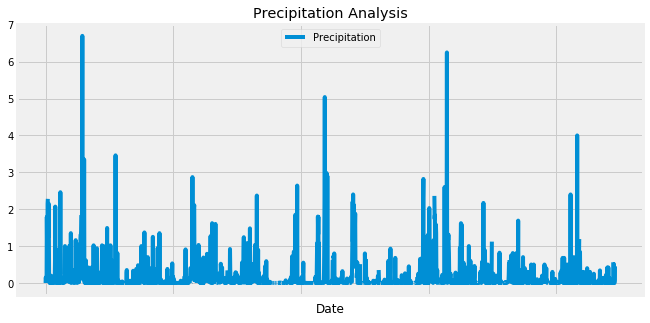

In [14]:
# Use Pandas Plotting with Matplotlib to `plot` the Data
prcp_df.plot(title="Precipitation Analysis", figsize=(10,5))
plt.legend(loc='upper center')
plt.savefig("Images/precipitation.png")
plt.show()

In [15]:
# Use Pandas to Calculate the Summary Statistics for the Precipitation Data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [16]:
# Design a Query to Show How Many Stations are Available in the Dataset
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [17]:
# Design a Query to Find the Most Active Stations
# List the Stations and Counts in Descending Order
# Which Station Had the Highest Number of Observations?
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the Station ID from the Previous Query, Calculate the Lowest Temperature Recorded, 
# Highest Temperature Recorded, and Average Temperature of the Most Active Station
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

min_max_avg_temp = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
min_max_avg_temp

[(54.0, 85.0, 71.66378066378067)]

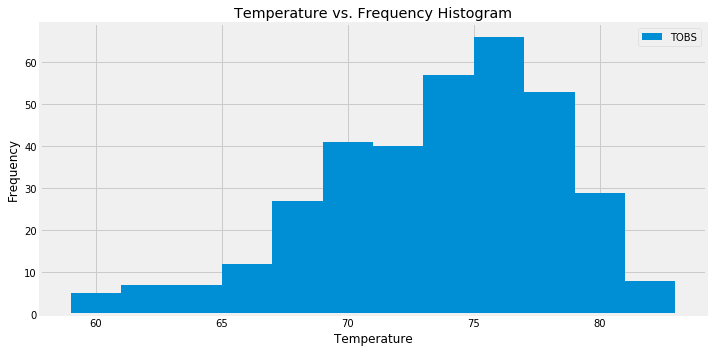

In [19]:
# Choose the Station with the Highest Number of Temperature Observations
# Design a Query to Retrieve the Last 12 Months of Temperature Observation Data for this Station
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["TOBS"])

# Plot the Results as a Histogram with `bins=12`
tobs_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(10,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/temperature_vs_frequency.png")
plt.show()

### Temperature Analysis 

In [20]:
# This Function Called `calc_temps` Will Accept Start Date and End Date in the Format `%Y-%m-%d` 
# and Return the Minimum, Average, and Maximum Temperatures for that Range of Dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function Usage Example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use the `calc_temps` Function to Calculate the min, avg, and max Temperatures for Your Trip 
# Using the Previous Year's Data for Those Same Dates
my_trip = calc_temps("2017-03-14", "2017-03-28")
my_trip

[(65.0, 73.12222222222222, 80.0)]

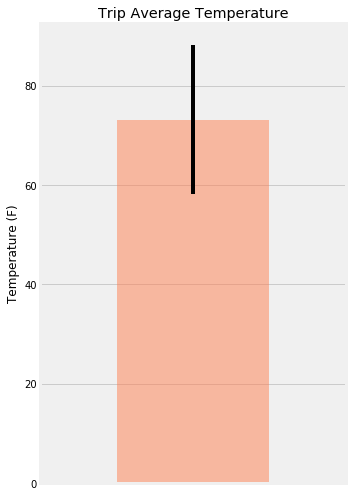

In [22]:
# Load the Results as a Pandas DataFrame
my_trip_df = pd.DataFrame(my_trip, columns=["TMIN", "TAVG", "TMAX"])

# Plot the min, avg, and max Temperatures from the Previous Query as a Bar Chart
# Use "Trip Average Temperature" as the Title
# Use the Average Temperature for the y Value
# Use the Peak-to-Peak (max-min) Value as the y Error Bar (yerr)
my_trip_df.plot.bar(y="TAVG", yerr=(my_trip_df["TMAX"] - my_trip_df["TMIN"]), 
                    title="Trip Average Temperature", color="coral", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("Images/trip_average_temperature.png")
plt.show()